<a href="https://colab.research.google.com/github/comparativechrono/computational_biology_notebooks/blob/main/link_equation_glm_glmm_worked_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

`Course:` **Mathematical & Computational Biology**  
`Module:` Understanding the link equation: GLM and GLMM  
`Author:` Tim Hearn  
`License:` CC-BY-4.0

# Understanding the Link Equation: GLM and GLMM

This notebook walks through the *link equation* conceptually and by simulation, first for a **generalised linear model (GLM)** and then for a **generalised linear mixed model (GLMM)**. Along the way we visualise common link functions and the effect of random effects.


## 1. Recap — Link equation for a GLM

For a response $Y_i$ in the exponential family we model

$$
g(\mu_i) = \eta_i = \mathbf{x}_i^{\top}\boldsymbol{\beta},
\qquad
\mu_i = \operatorname{E}[Y_i].
$$

The link function $g(\cdot)$ maps the mean to an unrestricted real-valued linear predictor $\eta_i$.



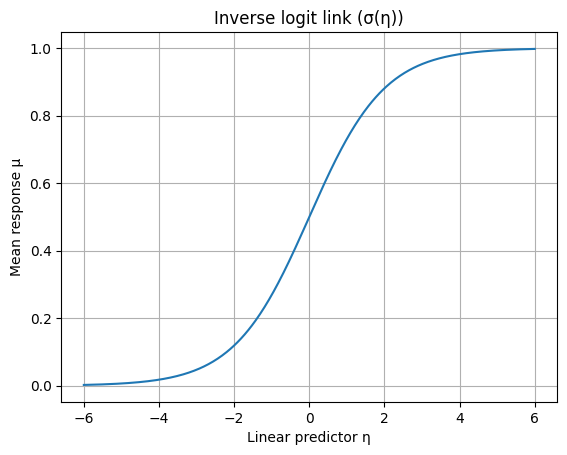

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Inverse logit curve
x = np.linspace(-6, 6, 500)
logistic = 1/(1 + np.exp(-x))

plt.plot(x, logistic)
plt.xlabel("Linear predictor η")
plt.ylabel("Mean response μ")
plt.title("Inverse logit link (σ(η))")
plt.grid(True)
plt.show()


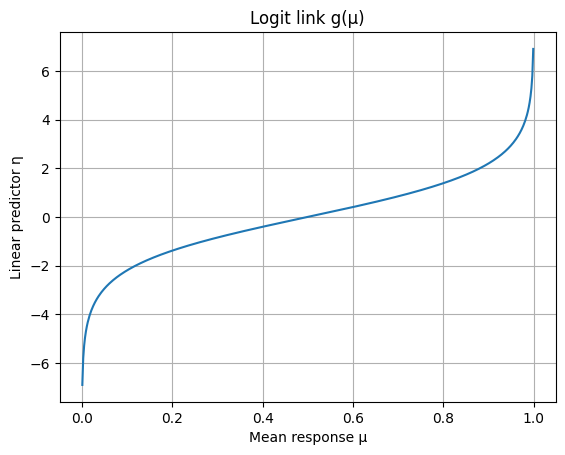

In [2]:
import numpy as np
import matplotlib.pyplot as plt

mu = np.linspace(0.001, 0.999, 500)
logit = np.log(mu/(1-mu))

plt.plot(mu, logit)
plt.xlabel("Mean response μ")
plt.ylabel("Linear predictor η")
plt.title("Logit link g(μ)")
plt.grid(True)
plt.show()


### 1.1 Simulating a logistic GLM
We now simulate binary data following a logistic‐link GLM and display the relationship between the covariate $x$ and the outcome $Y$.

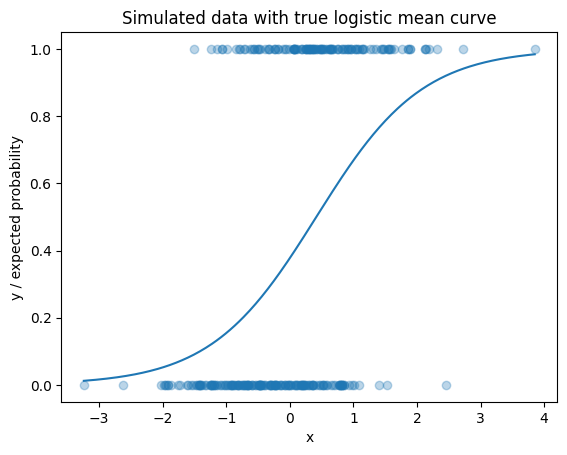

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
n = 300
x = np.random.normal(size=n)
eta = -0.5 + 1.2 * x
p = 1/(1 + np.exp(-eta))
y = np.random.binomial(1, p)

plt.scatter(x, y, alpha=0.3)
x_seq = np.linspace(x.min(), x.max(), 300)
p_seq = 1/(1 + np.exp(-(-0.5 + 1.2 * x_seq)))
plt.plot(x_seq, p_seq)
plt.xlabel("x")
plt.ylabel("y / expected probability")
plt.title("Simulated data with true logistic mean curve")
plt.show()


### 1.2 Seeing the linearity after applying the link
The logistic curve on the probability scale is curved, but on the **logit (link) scale** its relationship with the covariate becomes perfectly linear.
Below we plot the simulated linear predictor $\eta$ against $x$.

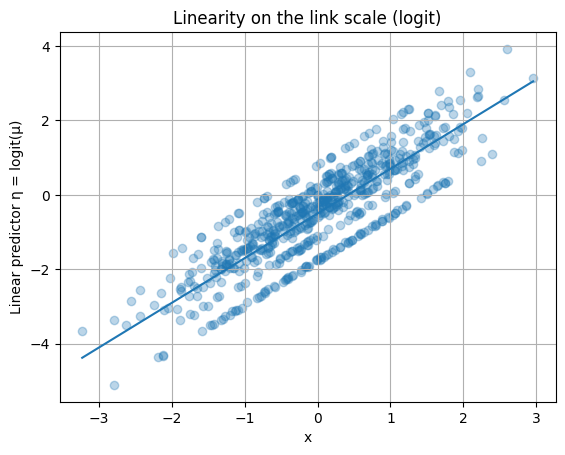

In [5]:
# Scatter of η vs x for the GLM simulation
plt.figure()
plt.scatter(x, eta, alpha=0.3)
x_seq = np.linspace(x.min(), x.max(), 300)
plt.plot(x_seq, -0.5 + 1.2 * x_seq)
plt.xlabel("x")
plt.ylabel("Linear predictor η = logit(μ)")
plt.title("Linearity on the link scale (logit)")
plt.grid(True)
plt.show()


**Empirical check:** Group the data into bins of $x$, compute the empirical proportion $\hat p$ in each bin, and take the logit transformation. Points should lie close to the theoretical straight line.

/tmp/ipython-input-3310833167.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby('bin').agg(x_mean=('x', 'mean'), p_hat=('y', 'mean')).dropna()


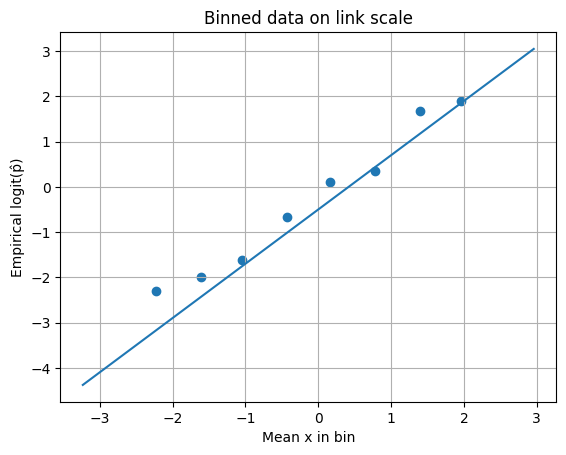

In [6]:
import pandas as pd
df = pd.DataFrame({'x': x, 'y': y})
df['bin'] = pd.cut(df['x'], bins=10)
bin_stats = df.groupby('bin').agg(x_mean=('x', 'mean'), p_hat=('y', 'mean')).dropna()
bin_stats = bin_stats[(bin_stats['p_hat']>0) & (bin_stats['p_hat']<1)]
bin_stats['logit_p'] = np.log(bin_stats['p_hat'] / (1 - bin_stats['p_hat']))

plt.figure()
plt.scatter(bin_stats['x_mean'], bin_stats['logit_p'])
plt.plot(x_seq, -0.5 + 1.2 * x_seq)
plt.xlabel("Mean x in bin")
plt.ylabel("Empirical logit(p̂)")
plt.title("Binned data on link scale")
plt.grid(True)
plt.show()


## 2. Extending to a GLMM

When data are clustered (e.g., students within schools), we introduce random effects $\mathbf{b}_j$:

$$
g\bigl(\operatorname{E}[Y_{ij} \mid \mathbf{b}_j]\bigr)
= \mathbf{x}_{ij}^{\top}\boldsymbol{\beta}
  + \mathbf{z}_{ij}^{\top}\mathbf{b}_j,
\qquad
\mathbf{b}_j \sim \mathcal{N}(\mathbf{0}, \mathbf{G}).
$$

The random part $\mathbf{z}_{ij}^{\top}\mathbf{b}_j$ lets each cluster have its own intercept and/or slopes.


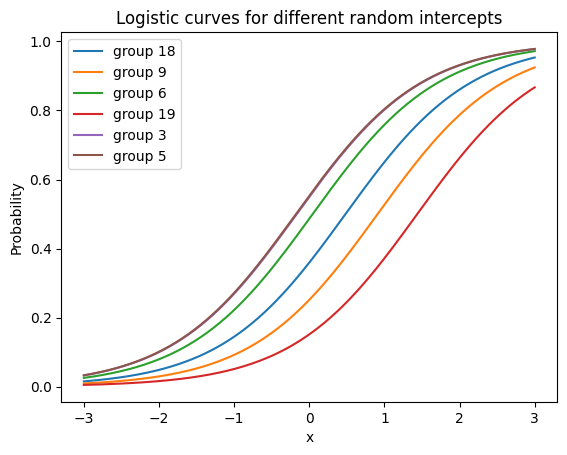

In [4]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)
n_groups = 20
group_sizes = np.random.randint(30, 40, size=n_groups)
group = np.repeat(np.arange(n_groups), group_sizes)
n = len(group)
x = np.random.normal(size=n)
b = np.random.normal(scale=0.8, size=n_groups)  # random intercepts
eta = -0.5 + 1.2 * x + b[group]
p = 1/(1 + np.exp(-eta))
y = np.random.binomial(1, p)

# Plot logistic curves for six random groups
plt.figure()
sample_groups = np.random.choice(n_groups, 6, replace=False)
x_plot = np.linspace(-3, 3, 300)
for g in sample_groups:
    eta_g = -0.5 + 1.2 * x_plot + b[g]
    p_g = 1/(1 + np.exp(-eta_g))
    plt.plot(x_plot, p_g, label=f"group {g}")
plt.xlabel("x")
plt.ylabel("Probability")
plt.title("Logistic curves for different random intercepts")
plt.legend()
plt.show()


### 2.1 Interpretation
The coloured curves show how each cluster‐specific random intercept shifts the logistic curve up or down on the probability scale, while sharing the same fixed slope **1.2** for covariate $x$. This illustrates the conditional mean $g^{-1}(\eta_{ij})$ varying by cluster.

## 2.2 Linearity in a GLMM (random intercepts)
On the logit scale, each cluster in a random-intercept GLMM is a **straight line** shifted by its random effect $b_j$.

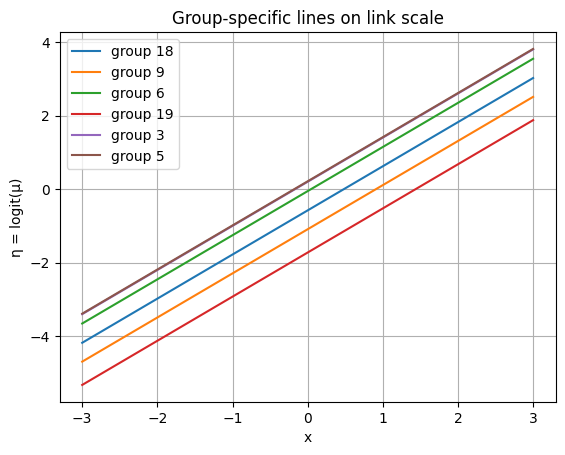

In [7]:
plt.figure()
for g in sample_groups:
    eta_g = -0.5 + 1.2 * x_plot + b[g]
    plt.plot(x_plot, eta_g, label=f"group {g}")
plt.xlabel("x")
plt.ylabel("η = logit(μ)")
plt.title("Group-specific lines on link scale")
plt.legend()
plt.grid(True)
plt.show()


## 3. Summary
* **GLM:** link function transforms the mean so we can model it linearly.
* **GLMM:** adds random effects, so the link equation includes both fixed and random terms.
Visualising the link and its inverse helps students see why the transformation is needed and how random effects shift the linear predictor.

Feel free to experiment: change the slope, the variance of the random intercepts, or switch to a different link (e.g., log link for Poisson counts) and re-run the simulations!